In [1]:
# we must prepare a non-default species config to avoid populating the breads repo with model data
config = '''
[species]
database = /Users/amadurowicz/species/species_database.hdf5
data_folder = /Users/amadurowicz/species/data/
vega_mag = 0.03
'''

# the species_config.ini must exist in the current working directory
with open("species_config.ini", "w") as config_file:
    config_file.write(config)

In [2]:
from breads.atm_utils import miniRGI, realRGI

import matplotlib.pyplot as plt
import numpy as np

species v0.9.0

Working folder: /Users/amadurowicz/breads/demos

Configuration file: /Users/amadurowicz/breads/demos/species_config.ini
Database file: /Users/amadurowicz/species/species_database.hdf5
Data folder: /Users/amadurowicz/species/data

Configuration settings:
   - Database: /Users/amadurowicz/species/species_database.hdf5
   - Data folder: /Users/amadurowicz/species/data
   - Magnitude of Vega: 0.03

Multiprocessing: mpi4py not installed


In [3]:
#I have to plot a model in 5 seconds or a bomb will detonate my cat

mRGI = miniRGI('atmo', wavelength_bounds=[1,15], R=100)

miniRGI model: miniRGI_atmo_1-15um_R100,
parameter bounds: {'teff': (200.0, 3000.0), 'logg': (2.5, 5.5)}
restricting wavelengths: 1 to 15 um
Spectral Resolution: 100
nothing to load... empty memory.


broadening... 2/2 
saving... /Users/amadurowicz/species/miniRGI/miniRGI_atmo_1-15um_R100.npy


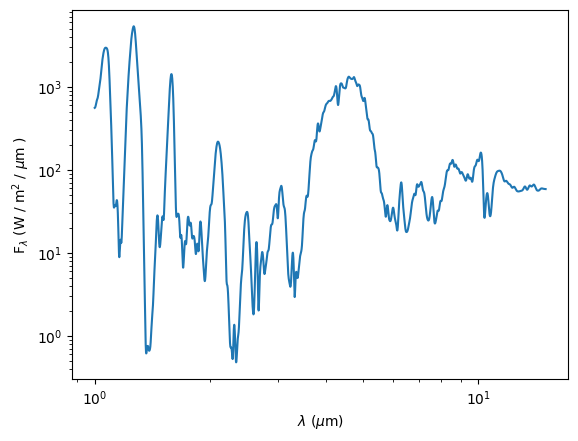

In [4]:
flux = mRGI([475,4])

plt.loglog(mRGI.wavelength,flux.reshape(-1))
plt.xlabel(r'$\lambda$ ($\mu$m)')
plt.ylabel(r'F$_\lambda$ (W / m$^2$ / $\mu$m )')
plt.show()

In [5]:
# I have plenty of time and around 150 GB of free disk space

In [6]:
from breads.atm_utils import download_all_models

# download_all_models() with no arguments will give you everything from the database, skipping models you already have.
# If you set clobber = True, this will enable redownloading and overwriting.
# You can also specify certain models to skip with skip = ['model_key']
# You can set verbose = False to silence all print statements.
# The vast majority of disk space is taken up by a few very high resolution and high dimensional grids which you may not need.

download_all_models(skip=['exo-rem-highres','sonora-elfowl-l','sonora-elfowl-t'], verbose = True, clobber = False)

skipping... ames-cond
skipping... ames-dusty
skipping... atmo
skipping... atmo-ceq
skipping... atmo-neq-weak
skipping... atmo-neq-strong
skipping... atmo-petrus2023
skipping... blackbody
skipping... bt-cond
skipping... bt-dusty
skipping... bt-cond-feh
skipping... bt-nextgen
skipping... bt-nextgen-subsolar
skipping... bt-settl
skipping... bt-settl-cifist
skipping... drift-phoenix
skipping... exo-rem
skipping... exo-rem-highres
skipping... koester-wd
skipping... lacy2023-clear-eq
skipping... lacy2023-clear-neq
skipping... lacy2023-cloudy-thin-eq
skipping... lacy2023-cloudy-thin-neq
skipping... lacy2023-cloudy-thick-eq
skipping... lacy2023-cloudy-thick-neq
skipping... morley-2012
skipping... petitcode-cool-clear
skipping... petitcode-cool-cloudy
skipping... petitcode-hot-clear
skipping... petitcode-hot-cloudy
skipping... petitcode-linder2019-clear
skipping... petitcode-linder2019-cloudy
skipping... phoenix-husser2013
skipping... saumon2008-clear
skipping... saumon2008-cloudy
skipping... s

In [7]:
model_name = 'sonora-elfowl-y'

# The miniRGI class is designed to be a lightweight and easy to use interpolator for atmospheric models.
# It relies heavily on the <species> package but adds features just for use with breads.
# You specify a model name and it produces an object which can called just like a <scipy.interpolate._rgi.RegularGridInterpolator>
# The main performance improvement is that it does not load the model grid into memory, except when you __call__ aka mRGI(atm_paras)
# This allows the function to "slice" the large model dataset in the HDF5 database, before loading them into memory, saving many GB.
# It also spoofs the existence of mRGI.values.shape using a fakeNDarray object, so you can see the full dimension of the grid before loading.

mRGI = miniRGI(model_name)
mwv = mRGI.wavelength

# The realRGI function is a helper tool which creates a genunine <scipy.interpolate._rgi.RegularGridInterpolator> object by loading the 
# full model grid of the name you have specified. It also returns the wavelength array. This can be very memory expensive but we will 
# use it for comparison to validate the accuracy of the miniRGI.

rwv,rRGI = realRGI(model_name)

type(mRGI),type(rRGI)

miniRGI model: miniRGI_sonora-elfowl-y,
parameter bounds: {'teff': (400.0, 550.0), 'logg': (3.25, 5.5), 'feh': (-1.0, 1.0), 'c_o_ratio': (0.5, 2.5), 'log_kzz': (2.0, 9.0)}
nothing to load... empty memory.


(breads.atm_utils.miniRGI, scipy.interpolate._rgi.RegularGridInterpolator)

In [8]:
# this test is taken from the forward model function
# hc_atmgrid_splinefm_jwst_nirspec_cal.py

def test_RGI(atm_grid,atm_paras):
    Natmparas = len(atm_grid.values.shape)-1
    planet_model = atm_grid(atm_paras)[0]
    return Natmparas,planet_model

testp1 = [450, 4, 0, 1, 7]        #points are directly on the defined grid points
testp2 = [470, 4.1, 0.1, .9, 6.7] #points are in-between adjacent grid points

for atm_paras in [testp1,testp2]:
    t1 = test_RGI(mRGI,atm_paras)
    t2 = test_RGI(rRGI,atm_paras)
    
    #Does the miniRGI provide the same values as the realRGI?
    print(np.all([np.all(mwv==rwv),t1[0]==t2[0],np.all(t1[1]==t2[1])]))

saving... /Users/amadurowicz/species/miniRGI/miniRGI_sonora-elfowl-y.npy
True
saving... /Users/amadurowicz/species/miniRGI/miniRGI_sonora-elfowl-y.npy
True


In [9]:
#How do the memory requirements compare?
from breads.atm_utils import object_memory_profiler

mRGI_mb = object_memory_profiler(mRGI,globals())/1024/1024
rRGI_mb = object_memory_profiler(rRGI,globals())/1024/1024

print()
print('miniRGI memory: {} MB, realRGI memory: {} MB'.format(np.round(mRGI_mb,2),np.round(rRGI_mb,2)))


!----! profiling: mRGI !----!
type: <class 'breads.atm_utils.miniRGI'>

 model_name 64
 wavelength_bounds 16
 R 16
 parallel_broadening_flag 28
 save_flag 28
 load_flag 28
 identity 72
 savedir 84
 fname 76
    teff 168
    logg 192
    feh 160
    c_o_ratio 144
    log_kzz 152
 points 816
    teff 56
    logg 56
    feh 56
    c_o_ratio 56
    log_kzz 56
 bounds 280
 wavelength 1545168
    shape 88
 values 88
       method 55
       bounds_error 28
       grid 80
       _descending_dimensions 40
       values 1545248
       fill_value 24
    [slice(2, 3, None), slice(3, 4, None), slice(2, 3, None), slice(1, 2, None), slice(2, 3, None), slice(None, None, None)] 1545475
       method 55
       bounds_error 28
       grid 80
       _descending_dimensions 40
       values 49441984
       fill_value 24
    [slice(2, 4, None), slice(3, 5, None), slice(2, 4, None), slice(0, 2, None), slice(1, 3, None), slice(None, None, None)] 49442211
 miniRGI_dictionary 50987686

!----! profiling: rRGI !-

In [10]:
del rRGI #its free RAM

In [11]:
# You can specify wavelength bounds as well as a spectral resolution R

broad_mRGI   = miniRGI(model_name,wavelength_bounds = [2.5, 5.5], R = 2700)
highres_mRGI = miniRGI(model_name,wavelength_bounds = [2.5, 5.5], R = None)

miniRGI model: miniRGI_sonora-elfowl-y_2.5-5.5um_R2700,
parameter bounds: {'teff': (400.0, 550.0), 'logg': (3.25, 5.5), 'feh': (-1.0, 1.0), 'c_o_ratio': (0.5, 2.5), 'log_kzz': (2.0, 9.0)}
restricting wavelengths: 2.5 to 5.5 um
Spectral Resolution: 2700
nothing to load... empty memory.
miniRGI model: miniRGI_sonora-elfowl-y_2.5-5.5um,
parameter bounds: {'teff': (400.0, 550.0), 'logg': (3.25, 5.5), 'feh': (-1.0, 1.0), 'c_o_ratio': (0.5, 2.5), 'log_kzz': (2.0, 9.0)}
restricting wavelengths: 2.5 to 5.5 um
nothing to load... empty memory.


In [12]:
testp3 = [430, 4.1, 0.1, .9, 6.7]

f1 = broad_mRGI(testp3)
f2 = highres_mRGI(testp3)

broadening... 32/32 
saving... /Users/amadurowicz/species/miniRGI/miniRGI_sonora-elfowl-y_2.5-5.5um_R2700.npy
saving... /Users/amadurowicz/species/miniRGI/miniRGI_sonora-elfowl-y_2.5-5.5um.npy


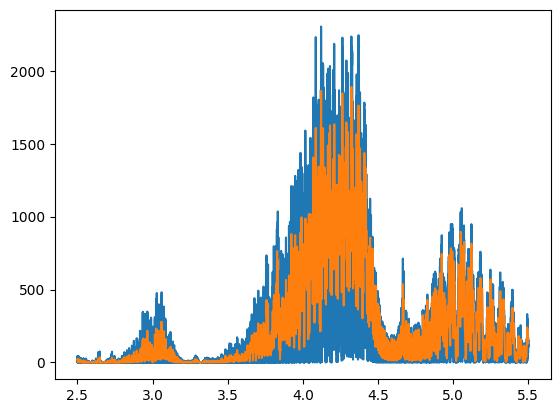

In [13]:
plt.plot(highres_mRGI.wavelength,f2[0])
plt.plot(broad_mRGI.wavelength,f1[0])
plt.show()

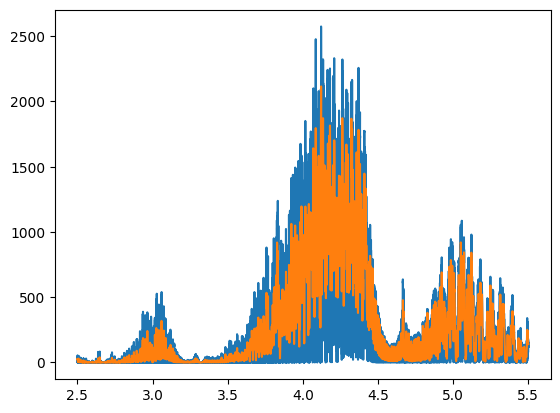

In [14]:
# If you call the model again with parameters in the same sub grid region it will remember the models loaded already

testp4 = [440, 4.2, 0.2, .8, 6.9]

f1 = broad_mRGI(testp4)
f2 = highres_mRGI(testp4)

plt.plot(highres_mRGI.wavelength,f2[0])
plt.plot(broad_mRGI.wavelength,f1[0])
plt.show()

broadening... 32/32 
saving... /Users/amadurowicz/species/miniRGI/miniRGI_sonora-elfowl-y_2.5-5.5um_R2700.npy
saving... /Users/amadurowicz/species/miniRGI/miniRGI_sonora-elfowl-y_2.5-5.5um.npy


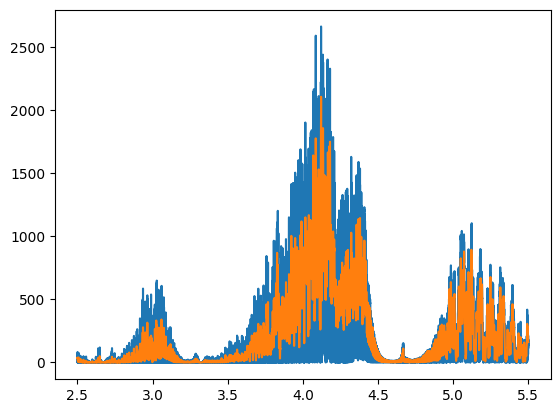

In [15]:
# If you cross into a new sub grid region it require more loading and broadening

testp5 = [455, 4.3, 0.6, 1.1, 7.2]

f1 = broad_mRGI(testp5)
f2 = highres_mRGI(testp5)

plt.plot(highres_mRGI.wavelength,f2[0])
plt.plot(broad_mRGI.wavelength,f1[0])
plt.show()

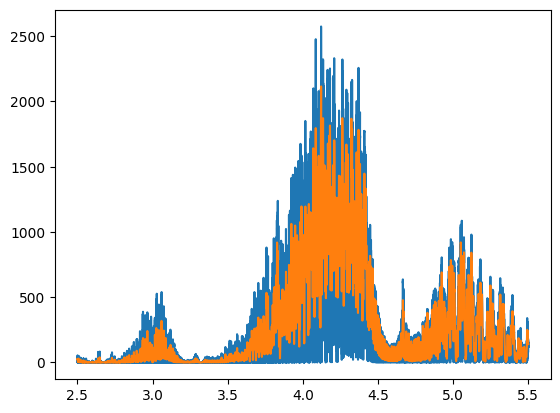

In [16]:
# But it will always remember previously loaded sub grid regions

testp4 = [440, 4.2, 0.2, .8, 6.9]

f1 = broad_mRGI(testp4)
f2 = highres_mRGI(testp4)

plt.plot(highres_mRGI.wavelength,f2[0])
plt.plot(broad_mRGI.wavelength,f1[0])
plt.show()

In [17]:
# This is possible because each sub grid region is stored as a unique interpolator object 
# in a dictionary indexed by a string of slicing parameters for the hdf5 database

broad_mRGI.miniRGI_dictionary

{'[slice(1, 3, None), slice(3, 5, None), slice(2, 4, None), slice(0, 2, None), slice(1, 3, None), slice(85627, 132934, None)]': <scipy.interpolate._rgi.RegularGridInterpolator at 0x30467bd90>,
 '[slice(2, 4, None), slice(4, 6, None), slice(3, 5, None), slice(1, 3, None), slice(2, 4, None), slice(85627, 132934, None)]': <scipy.interpolate._rgi.RegularGridInterpolator at 0x304731d90>}

In [18]:
from breads.atm_utils import viable_models, valid_models

In [19]:
# Calling viable_models() returns two lists, one of all of the model keys you already downloaded,
# and another for every possible model key which can be downloaded.

downloaded_models, available_models = viable_models()

/opt/miniconda3/envs/stenv/lib/python3.11/site-packages/species/read/read_model.py:71: UserWarning: It is recommended to use the CIFIST grid of the BT-Settl, because it is a newer version. In that case, set model='bt-settl-cifist' when using add_model of Database.
  warnings.warn(


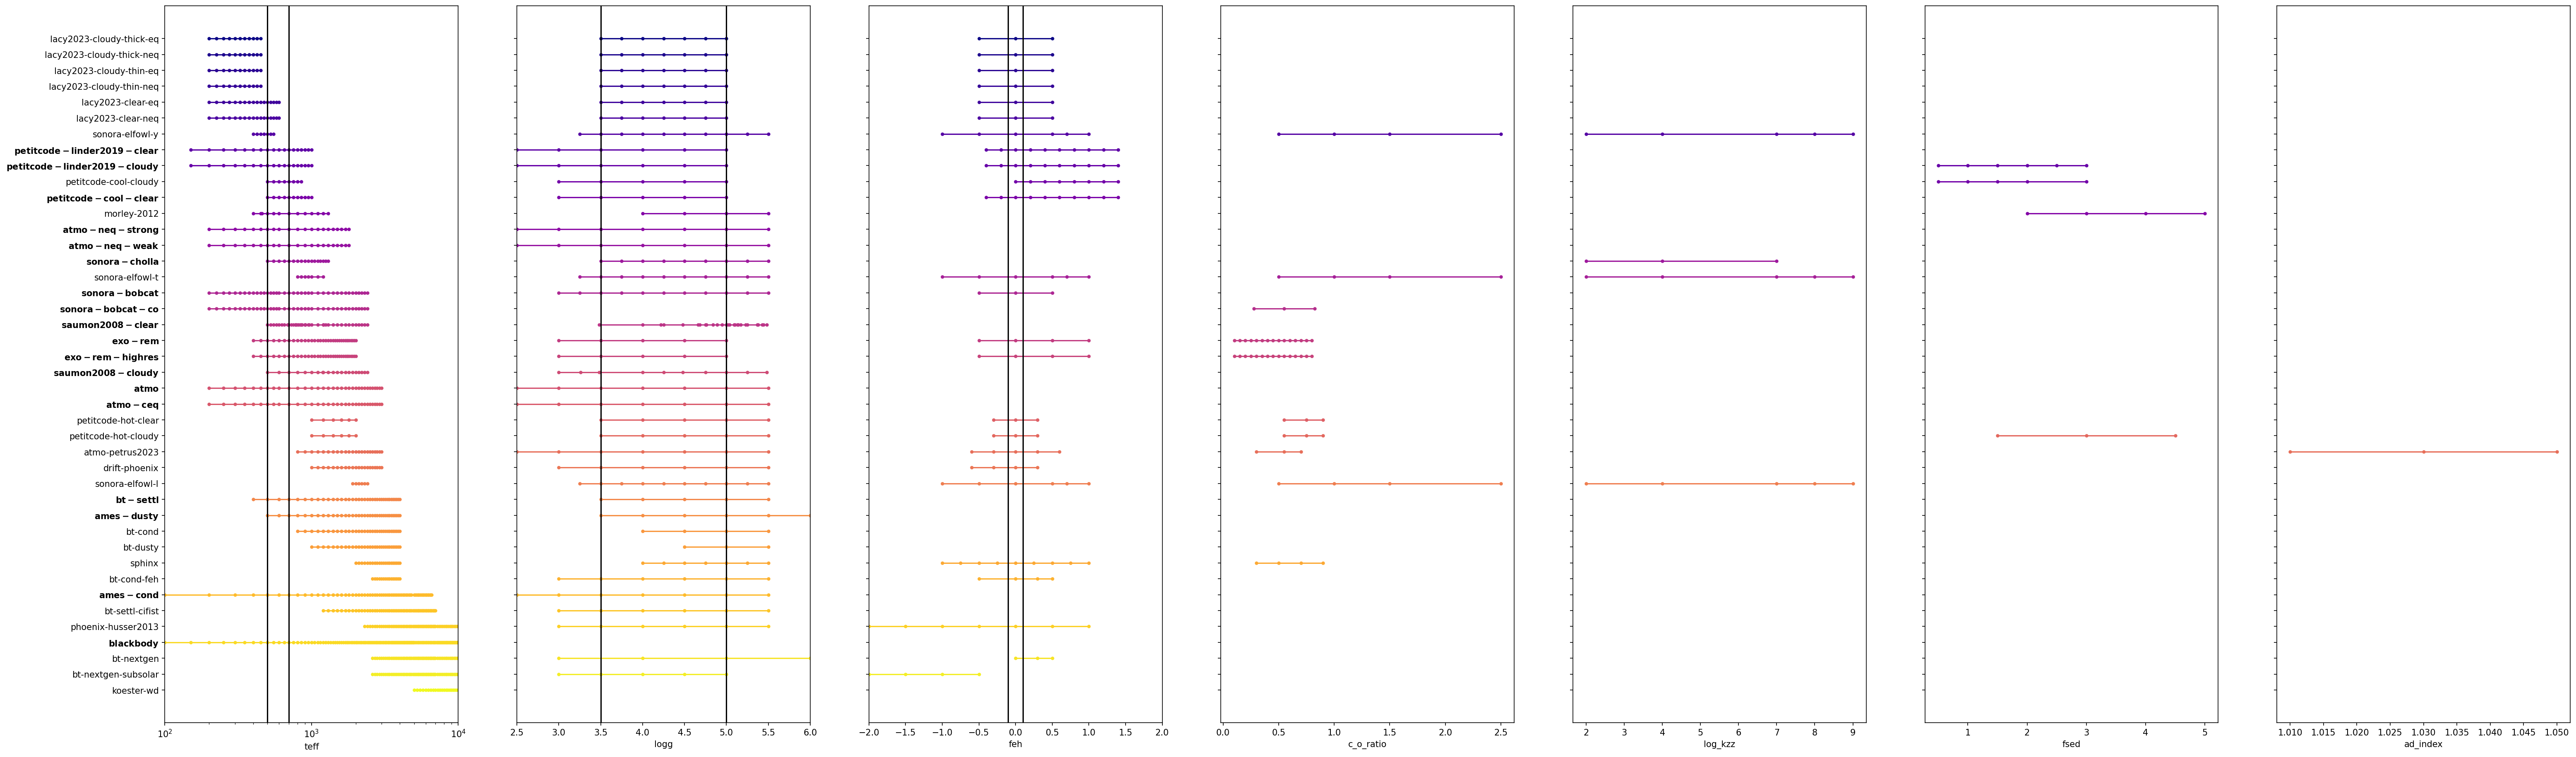

array(['ames-cond', 'ames-dusty', 'atmo', 'atmo-ceq', 'atmo-neq-strong',
       'atmo-neq-weak', 'blackbody', 'bt-settl', 'exo-rem',
       'exo-rem-highres', 'petitcode-cool-clear',
       'petitcode-linder2019-clear', 'petitcode-linder2019-cloudy',
       'saumon2008-clear', 'saumon2008-cloudy', 'sonora-bobcat',
       'sonora-bobcat-co', 'sonora-cholla'], dtype='<U27')

In [22]:
# valid_models(keylist, bounds) will search for models in the keylist which are consistent with a dictionary of specified bounds.

search_bounds = {}
search_bounds['teff']      = (500, 700)
search_bounds['logg']      = (3.5,5)
search_bounds['feh']       = (-0.1,0.1)
search_bounds['c_o_ratio'] = None
search_bounds['log_kzz']   = None
search_bounds['fsed']      = None
search_bounds['ad_index']  = None

# A model is valid if every parameter the grid is defined has grid points which fully cover the range specified by the bounds.
# The bounds are not checked for parameters which the grid does not define.
# If the bounds are not defined, any range of values for that parameters are deemed acceptable.

valid_keylist = valid_models(downloaded_models,search_bounds,plotflag=True)
valid_keylist